In [2]:
%load_ext autoreload
%autoreload 2

from pathlib import Path
import sys
path = str(Path(Path('File.py').parent.absolute()).parent.absolute())
sys.path.insert(0, path)

import numpy as np
import matplotlib as mlab
import matplotlib.pyplot as plt
import xarray as xr
import os as os
import glob
import matplotlib.gridspec as gridspec
from collections import namedtuple

#from Plot_tools import *
from File_tools import *

import pickle

_nthreads = 2


In [ ]:
w_thresh = 3.0
cref_thresh = 40.
percent = (50,75,90)

in_dir  = "/work/wicker/Odin_scr/solo"
out_dir = "/work/wicker/Odin_scr/solo"
prefix  = "squall_3km"

allcape = ("C1500", "C2000", "C2500", "C3000", "C3500")
allshear = ("06","12", "18")

solo = {}
cm1  = {}
wrf  = {}

for shear in allshear:
    for cape in allcape:
        
        label = "%s_%s" % (cape, shear)

        solo_file = str(os.path.join(in_dir, "%s_%s" % (prefix, label)))
        print(solo_file)
        solo[label] = generate_ideal_profiles(solo_file, filename="atmos_hifreq.nc", model_type='fv3_solo', w_thresh = w_thresh, cref_thresh = cref_thresh, percentiles=percent)
        
        wrf_file = str(os.path.join("/work/wicker/WRF/WRF/test/em_quarter_ss", "%s_%s" % (prefix, label)))
        print(wrf_file)
        wrf[label] = generate_ideal_profiles(wrf_file, model_type='wrf', w_thresh = w_thresh, cref_thresh = cref_thresh, percentiles=percent, compDBZ=True)
                 
        cm1_file = str(os.path.join("/work/wicker/Odin_scr/cm1r20.3/run", "%s_%s" % (prefix, label)))
        print(cm1_file)
        cm1[label] = generate_ideal_profiles(cm1_file, model_type='cm1', w_thresh = w_thresh, cref_thresh = cref_thresh, percentiles=percent)
        
with open('solo_profiles.pkl', 'wb') as handle:
    pickle.dump(solo, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('wrf_profiles.pkl', 'wb') as handle:
    pickle.dump(wrf, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('cm1_profiles.pkl', 'wb') as handle:
    pickle.dump(cm1, handle, protocol=pickle.HIGHEST_PROTOCOL)


/work/wicker/Odin_scr/solo/squall_3km_C1500_06
processing model run:  /work/wicker/Odin_scr/solo/squall_3km_C1500_06 

Reading:  /work/wicker/Odin_scr/solo/squall_3km_C1500_06/atmos_hifreq.nc 
(60, 525)

 Number of selected updraft profiles:  525 
 Number of labeled objects:  547

Percentile value:  50.000000

Percentile value:  75.000000

Percentile value:  90.000000

/work/wicker/WRF/WRF/test/em_quarter_ss/squall_3km_C1500_06
processing model run:  /work/wicker/WRF/WRF/test/em_quarter_ss/squall_3km_C1500_06 

Reading:  /work/wicker/WRF/WRF/test/em_quarter_ss/squall_3km_C1500_06/wrfout_d01_0001-01-01_00:00:00 

Reading external DBZ file: /work/wicker/WRF/WRF/test/em_quarter_ss/squall_3km_C1500_06/wrf_dbz.npy

Shape of DBZ array:  (25, 60, 255, 255)
(60, 711)

 Number of selected updraft profiles:  711 
 Number of labeled objects:  734

Percentile value:  50.000000

Percentile value:  75.000000

Percentile value:  90.000000

/work/wicker/Odin_scr/cm1r20.3/run/squall_3km_C1500_06
proces

In [27]:
# Just read stuff back in...
            
cm1 = pickle2Obj('cm1_profiles.pkl')
wrf = pickle2Obj('wrf_profiles.pkl')
fv3 = pickle2Obj('solo_profiles.pkl')


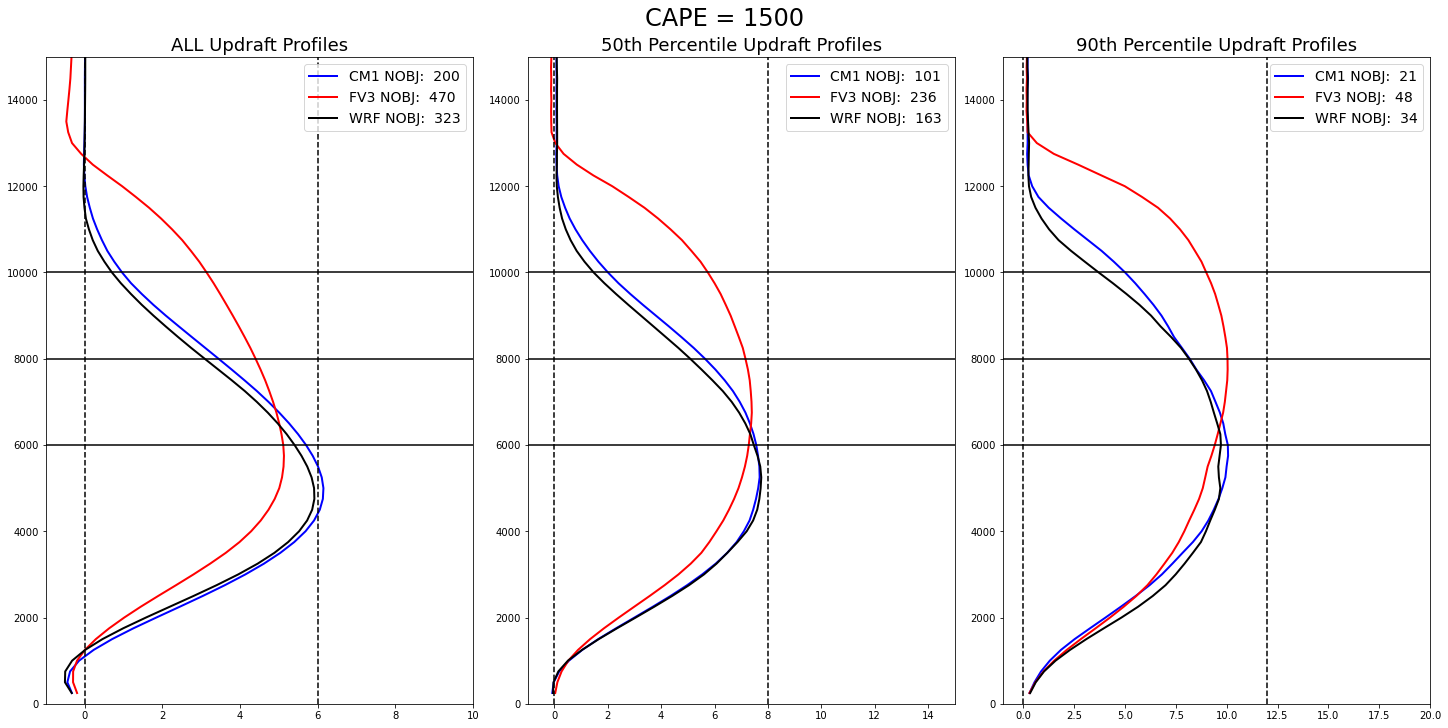

In [62]:
#--------------------------------------------------------------------------------------------
def plot_wprofile(profile, zhgts, percentile, ax, color, mlabel, linewidth=2.0, linestyle='solid'):

    label = "%s NOBJ:  %d" % (mlabel, profile[percentile].shape[1])
    
    ax.plot(profile[percentile].mean(axis=1), zhgts, color=color, linewidth=linewidth, label=label, linestyle=linestyle)
#--------------------------------------------------------------------------------------------
# main

titles = ["ALL Updraft Profiles", "50th Percentile Updraft Profiles", "90th Percentile Updraft Profiles"]

xvert  = [6.0, 8.0, 12.5]
xlim   = [10., 15.0, 20.0]

zhgts = 250. + 250.*np.arange(60)

fig, ax = plt.subplots(1,3, constrained_layout=True,figsize=(20,10))

for m in [0,1,3]:
            
    n = m
    if m == 3: n=2
    plot_wprofile(cm1.cm1_c1500, zhgts, m, ax[n], 'b', 'CM1')              
    plot_wprofile(fv3.fv3_c1500, zhgts, m, ax[n], 'r',  'FV3')
    plot_wprofile(wrf.wrf_c1500, zhgts, m, ax[n], 'k', 'WRF')
    
    ax[n].set_title("%s" % titles[n], fontsize=18)
    ax[n].axhline(y=6000., color='k', linestyle='-')
    ax[n].axhline(y=8000., color='k', linestyle='-')
    ax[n].axhline(y=10000., color='k', linestyle='-')
    ax[n].axvline(x=0.0, color='k', linestyle='--')
    ax[n].axvline(x=xvert[n], color='k', linestyle='--')

    ax[n].set_ylim(0.0,15000.)
    ax[n].set_xlim(-1.0,xlim[n])
    ax[n].legend(fontsize=14, loc='upper right')

plt.suptitle("CAPE = 1500", fontsize=24)
plt.show()

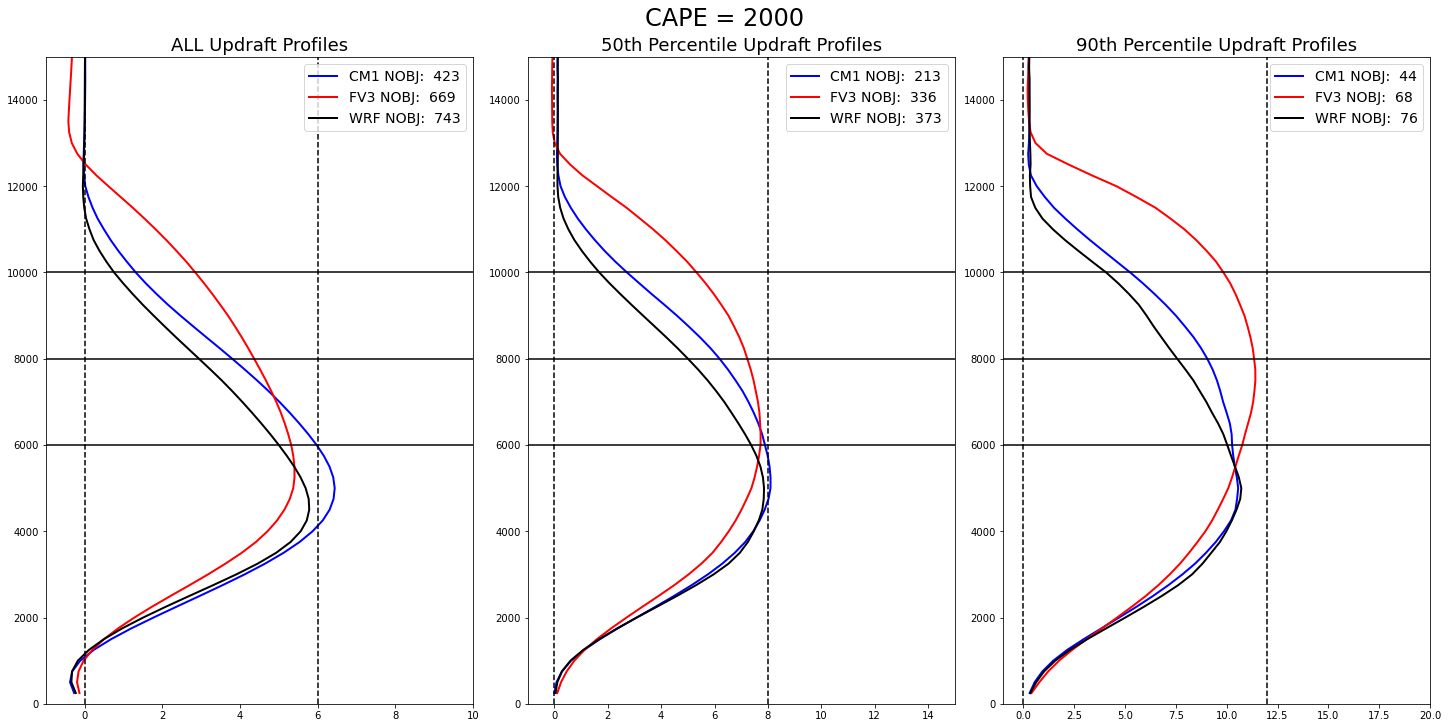

In [63]:
#--------------------------------------------------------------------------------------------
# main

fig, ax = plt.subplots(1,3, constrained_layout=True,figsize=(20,10))

for m in [0,1,3]:
            
    n = m
    if m == 3: n=2
    plot_wprofile(cm1.cm1_c2000, zhgts, m, ax[n], 'b', 'CM1')              
    plot_wprofile(fv3.fv3_c2000, zhgts, m, ax[n], 'r',  'FV3')
    plot_wprofile(wrf.wrf_c2000, zhgts, m, ax[n], 'k', 'WRF')
    
    ax[n].set_title("%s" % titles[n], fontsize=18)
    ax[n].axhline(y=6000., color='k', linestyle='-')
    ax[n].axhline(y=8000., color='k', linestyle='-')
    ax[n].axhline(y=10000., color='k', linestyle='-')
    ax[n].axvline(x=0.0, color='k', linestyle='--')
    ax[n].axvline(x=xvert[n], color='k', linestyle='--')

    ax[n].set_ylim(0.0,15000.)
    ax[n].set_xlim(-1.0,xlim[n])
    ax[n].legend(fontsize=14,loc='upper right')

plt.suptitle("CAPE = 2000", fontsize=24)
plt.show()

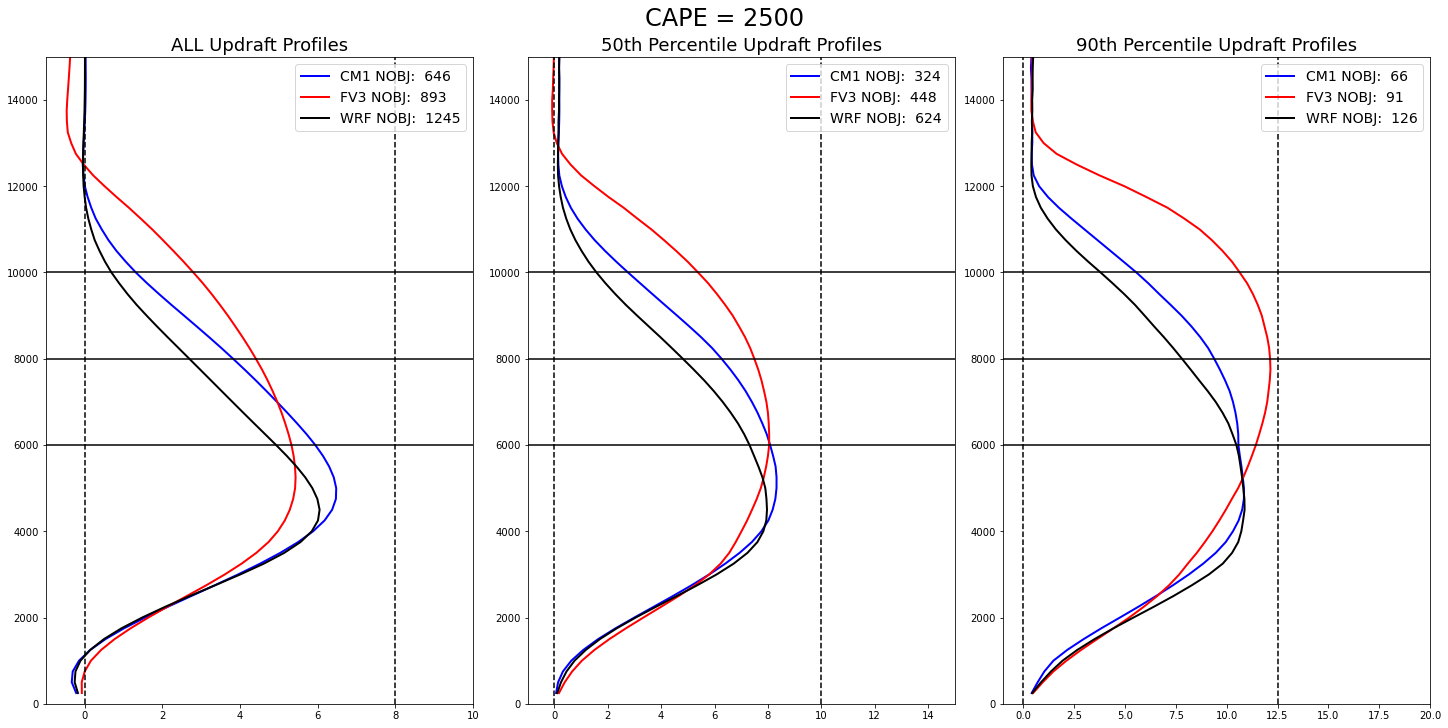

In [73]:
xvert  = [8.0, 10.0, 12.5]
fig, ax = plt.subplots(1,3, constrained_layout=True,figsize=(20,10))

for m in [0,1,3]:
            
    n = m
    if m == 3: n=2
    plot_wprofile(cm1.cm1_c2500, zhgts, m, ax[n], 'b', 'CM1')              
    plot_wprofile(fv3.fv3_c2500, zhgts, m, ax[n], 'r',  'FV3')
    plot_wprofile(wrf.wrf_c2500, zhgts, m, ax[n], 'k', 'WRF')
    
    ax[n].set_title("%s" % titles[n], fontsize=18)
    ax[n].axhline(y=6000., color='k', linestyle='-')
    ax[n].axhline(y=8000., color='k', linestyle='-')
    ax[n].axhline(y=10000., color='k', linestyle='-')
    ax[n].axvline(x=0.0, color='k', linestyle='--')
    ax[n].axvline(x=xvert[n], color='k', linestyle='--')

    ax[n].set_ylim(0.0,15000.)
    ax[n].set_xlim(-1.0,xlim[n])
    ax[n].legend(fontsize=14, loc='upper right')

plt.suptitle("CAPE = 2500", fontsize=24)
plt.show()

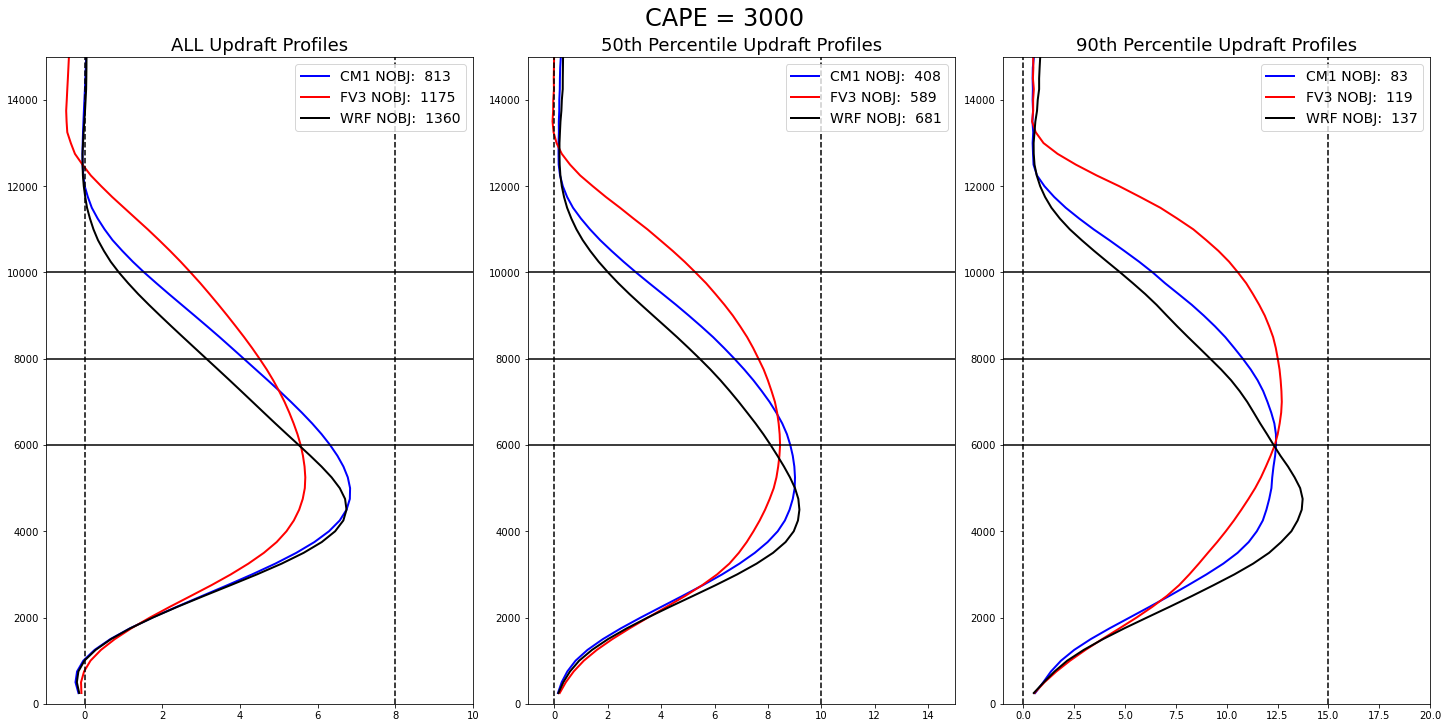

In [70]:
xvert  = [8.0, 10.0, 15.0]
zhgts = 250. + 250.*np.arange(60)

fig, ax = plt.subplots(1,3, constrained_layout=True,figsize=(20,10))

for m in [0,1,3]:
            
    n = m
    if m == 3: n=2
    plot_wprofile(cm1.cm1_c3000, zhgts, m, ax[n], 'b', 'CM1')              
    plot_wprofile(fv3.fv3_c3000, zhgts, m, ax[n], 'r',  'FV3')
    plot_wprofile(wrf.wrf_c3000, zhgts, m, ax[n], 'k', 'WRF')
    
    ax[n].set_title("%s" % titles[n], fontsize=18)
    ax[n].axhline(y=6000., color='k', linestyle='-')
    ax[n].axhline(y=8000., color='k', linestyle='-')
    ax[n].axhline(y=10000., color='k', linestyle='-')
    ax[n].axvline(x=0.0, color='k', linestyle='--')
    ax[n].axvline(x=xvert[n], color='k', linestyle='--')

    ax[n].set_ylim(0.0,15000.)
    ax[n].set_xlim(-1.0,xlim[n])
    ax[n].legend(fontsize=14, loc='upper right')

plt.suptitle("CAPE = 3000", fontsize=24)
plt.show()

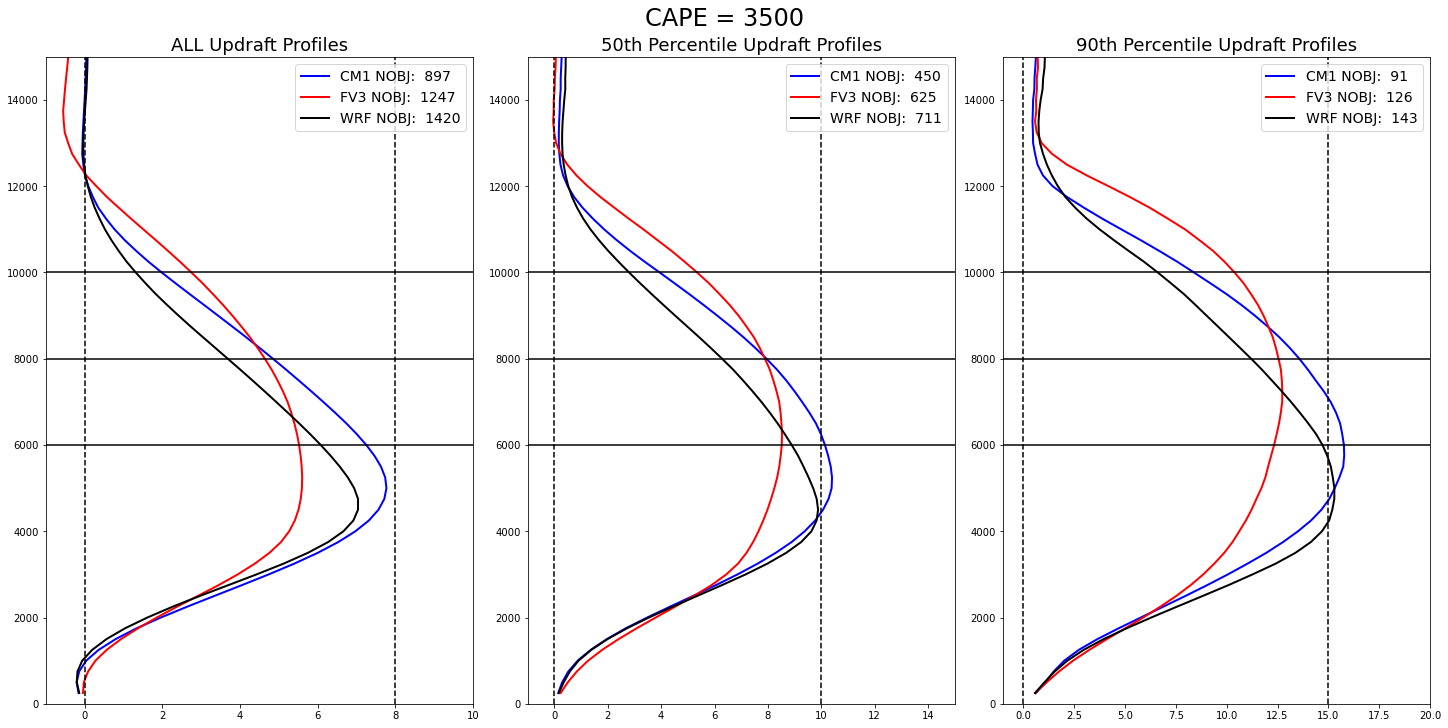

In [69]:
xvert  = [8.0, 10.0, 15.0]
fig, ax = plt.subplots(1,3, constrained_layout=True,figsize=(20,10))

for m in [0,1,3]:
            
    n = m
    if m == 3: n=2
    plot_wprofile(cm1.cm1_c3500, zhgts, m, ax[n], 'b', 'CM1')              
#plot_wprofile(cm1.cm1_c3500_eq1, zhgts, m, ax[n], 'b', 'CM1_c3500_eq1', linestyle='dashed')
    plot_wprofile(fv3.fv3_c3500, zhgts, m, ax[n], 'r',    'FV3')
    plot_wprofile(wrf.wrf_c3500, zhgts, m, ax[n], 'k', 'WRF')
    
    ax[n].set_title("%s" % titles[n], fontsize=18)
    ax[n].axhline(y=6000., color='k', linestyle='-')
    ax[n].axhline(y=8000., color='k', linestyle='-')
    ax[n].axhline(y=10000., color='k', linestyle='-')
    ax[n].axvline(x=0.0, color='k', linestyle='--')
    ax[n].axvline(x=xvert[n], color='k', linestyle='--')

    ax[n].set_ylim(0.0,15000.)
    ax[n].set_xlim(-1.0,xlim[n])
    ax[n].legend(fontsize=14, loc='upper right')

plt.suptitle("CAPE = 3500", fontsize=24)
plt.show()

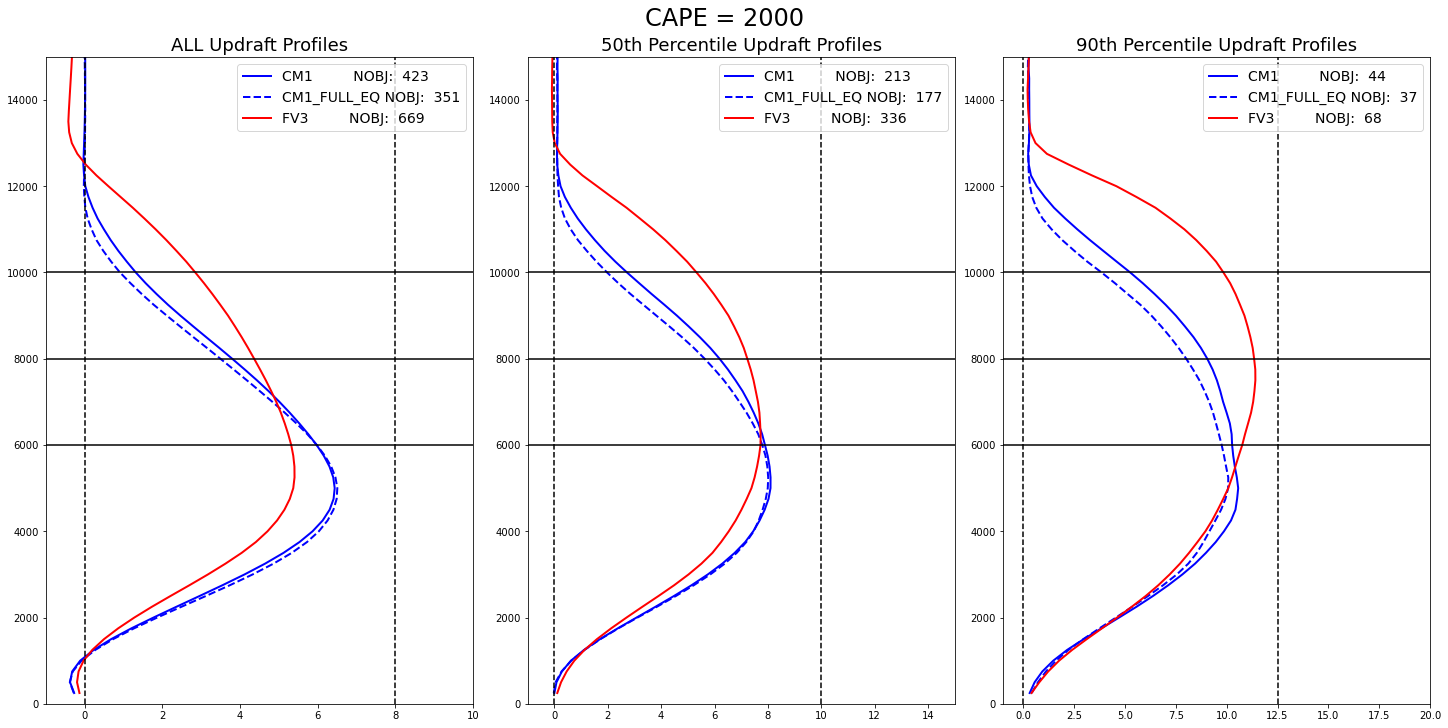

In [78]:
#--------------------------------------------------------------------------------------------
# main

fig, ax = plt.subplots(1,3, constrained_layout=True,figsize=(20,10))

for m in [0,1,3]:
            
    n = m
    if m == 3: n=2
    plot_wprofile(cm1.cm1_c2000, zhgts, m, ax[n], 'b',     'CM1        ') 
    plot_wprofile(cm1.cm1_c2000_eq1, zhgts, m, ax[n], 'b', 'CM1_FULL_EQ', linestyle='--')  
    plot_wprofile(fv3.fv3_c2000, zhgts, m, ax[n], 'r',     'FV3        ')
    
    ax[n].set_title("%s" % titles[n], fontsize=18)
    ax[n].axhline(y=6000., color='k', linestyle='-')
    ax[n].axhline(y=8000., color='k', linestyle='-')
    ax[n].axhline(y=10000., color='k', linestyle='-')
    ax[n].axvline(x=0.0, color='k', linestyle='--')
    ax[n].axvline(x=xvert[n], color='k', linestyle='--')

    ax[n].set_ylim(0.0,15000.)
    ax[n].set_xlim(-1.0,xlim[n])
    ax[n].legend(fontsize=14,loc='upper right')

plt.suptitle("CAPE = 2000", fontsize=24)
plt.show()

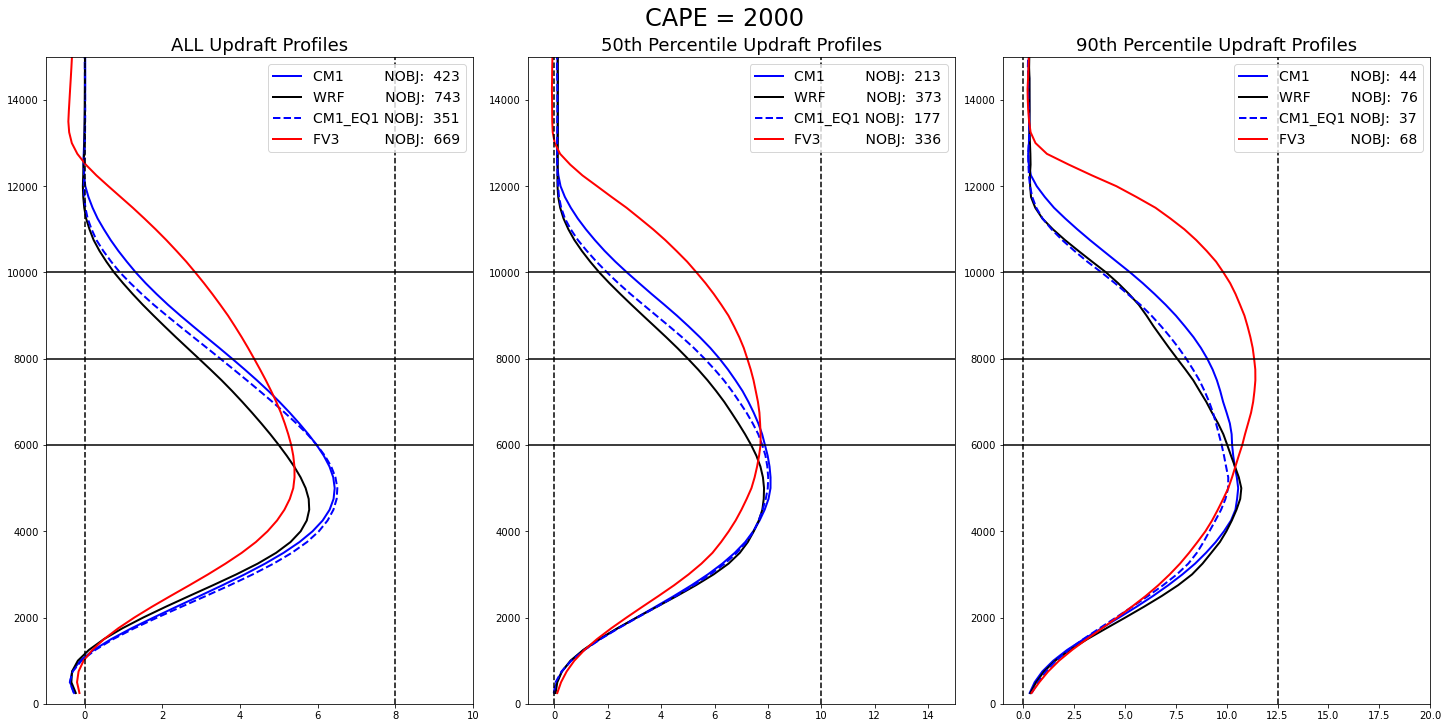

In [90]:
#--------------------------------------------------------------------------------------------
# main

fig, ax = plt.subplots(1,3, constrained_layout=True,figsize=(20,10))

for m in [0,1,3]:
            
    n = m
    if m == 3: n=2
    plot_wprofile(cm1.cm1_c2000, zhgts, m, ax[n], 'b',     'CM1        ') 
    plot_wprofile(wrf.wrf_c2000, zhgts, m, ax[n], 'k',     'WRF        ') 
    plot_wprofile(cm1.cm1_c2000_eq1, zhgts, m, ax[n], 'b', 'CM1_EQ1', linestyle='--')  
    plot_wprofile(fv3.fv3_c2000, zhgts, m, ax[n], 'r',     'FV3         ')
    
    ax[n].set_title("%s" % titles[n], fontsize=18)
    ax[n].axhline(y=6000., color='k', linestyle='-')
    ax[n].axhline(y=8000., color='k', linestyle='-')
    ax[n].axhline(y=10000., color='k', linestyle='-')
    ax[n].axvline(x=0.0, color='k', linestyle='--')
    ax[n].axvline(x=xvert[n], color='k', linestyle='--')

    ax[n].set_ylim(0.0,15000.)
    ax[n].set_xlim(-1.0,xlim[n])
    ax[n].legend(fontsize=14,loc='upper right')

plt.suptitle("CAPE = 2000", fontsize=24)
plt.show()

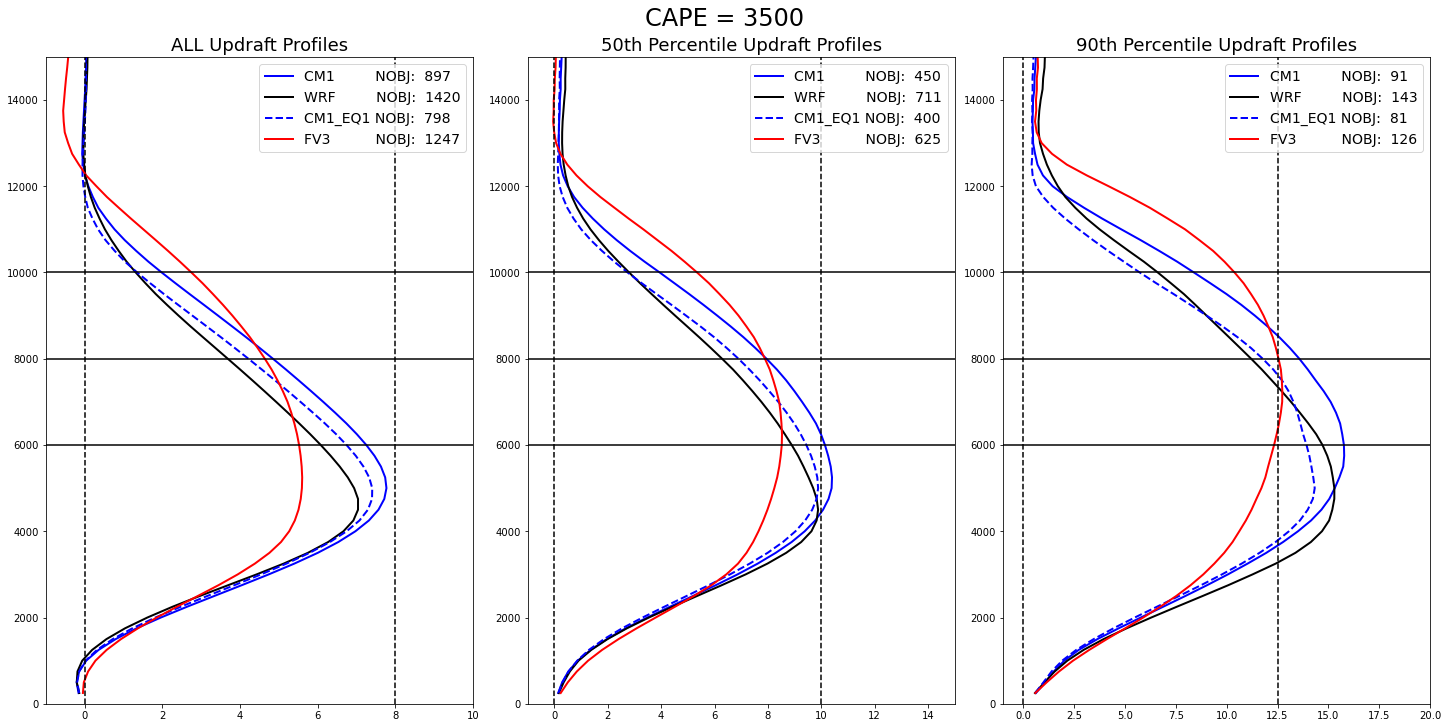

In [89]:
#--------------------------------------------------------------------------------------------
# main

fig, ax = plt.subplots(1,3, constrained_layout=True,figsize=(20,10))

for m in [0,1,3]:
            
    n = m
    if m == 3: n=2
    plot_wprofile(cm1.cm1_c3500, zhgts, m, ax[n], 'b',     'CM1        ') 
    plot_wprofile(wrf.wrf_c3500, zhgts, m, ax[n], 'k',     'WRF        ') 
    plot_wprofile(cm1.cm1_c3500_eq1, zhgts, m, ax[n], 'b', 'CM1_EQ1', linestyle='--')  
    plot_wprofile(fv3.fv3_c3500, zhgts, m, ax[n], 'r',     'FV3         ')
    
    ax[n].set_title("%s" % titles[n], fontsize=18)
    ax[n].axhline(y=6000., color='k', linestyle='-')
    ax[n].axhline(y=8000., color='k', linestyle='-')
    ax[n].axhline(y=10000., color='k', linestyle='-')
    ax[n].axvline(x=0.0, color='k', linestyle='--')
    ax[n].axvline(x=xvert[n], color='k', linestyle='--')

    ax[n].set_ylim(0.0,15000.)
    ax[n].set_xlim(-1.0,xlim[n])
    ax[n].legend(fontsize=14,loc='upper right')

plt.suptitle("CAPE = 3500", fontsize=24)
plt.show()

AttributeError: 'dict' object has no attribute 'fv3_c2000'

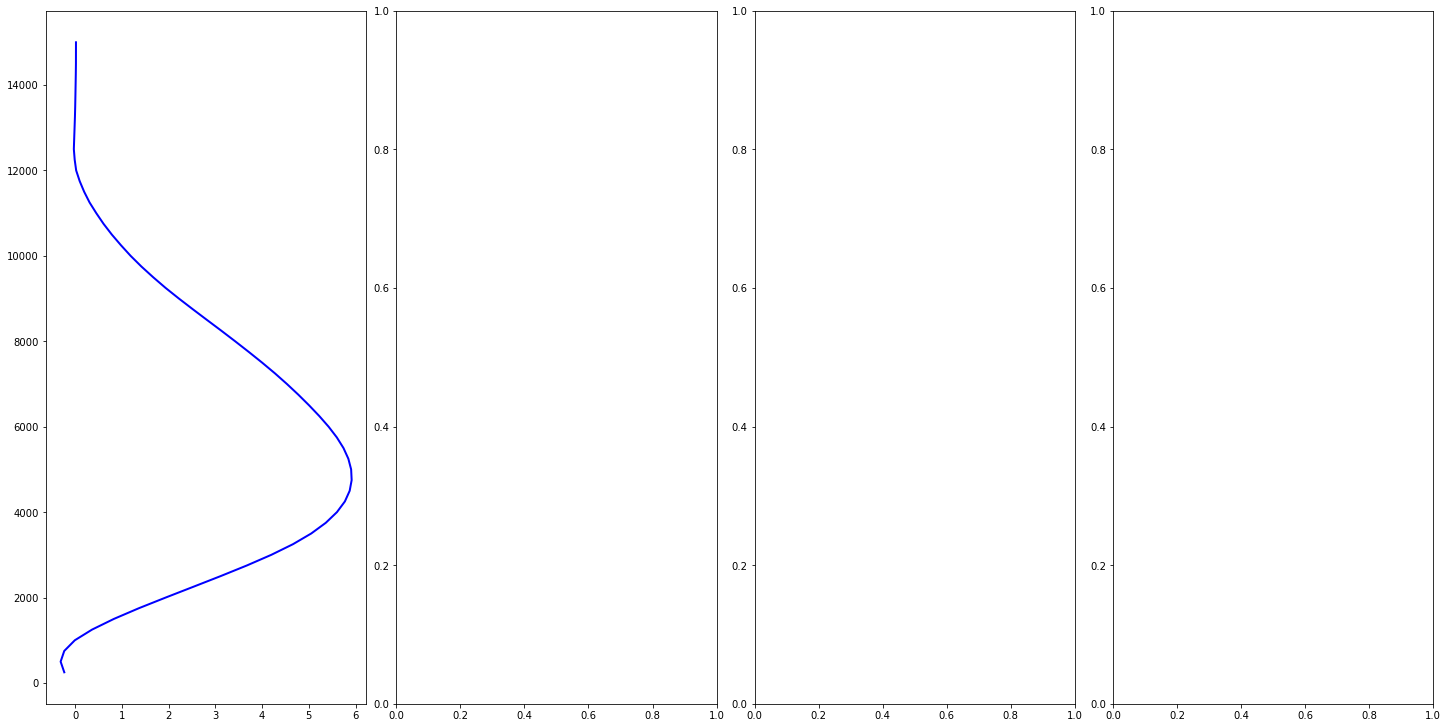

In [6]:
#--------------------------------------------------------------------------------------------
# main

titles = ["ALL Updraft Profiles", "75th Percentile Updraft Profiles", "90th Percentile Updraft Profiles", "95th Percentile Updraft Profiles"]

xvert  = [8.0, 10.0, 15.0, 17.5]
xlim   = [12.5, 15.0, 20.0, 20.0]

zhgts = 250. + 250.*np.arange(60)

fig, ax = plt.subplots(1,4, constrained_layout=True,figsize=(20,10))

for n in np.arange(4):
                   
    plot_wprofile(cm1.cm1_c2000, zhgts, n, ax[n], 'b', 'CM1_CPM')              
    #plot_wprofile(cm1.cm1_c2000_eq1, zhgts, n, ax[n], 'b', 'CM1_eq1', linestyle='dashed')
    plot_wprofile(fv3.fv3_c2000, zhgts, n, ax[n], 'r',    'FV3_CVM')
#plot_wprofile(fv3.fv3_c2000_cp, zhgts, n, ax[n], 'r', 'FV3_CP', linestyle='dotted')
    plot_wprofile(fv3_c2000_cpm, zhgts, n, ax[n], 'r', 'FV3_CPM', linestyle='dashed')
    plot_wprofile(wrf.wrf_c2000, zhgts, n, ax[n], 'k', 'WRF_c3500')
    
    ax[n].set_title("%s" % titles[n], fontsize=18)
    ax[n].axhline(y=6000., color='k', linestyle='-')
    ax[n].axhline(y=8000., color='k', linestyle='-')
    ax[n].axhline(y=10000., color='k', linestyle='-')
    ax[n].axvline(x=0.0, color='k', linestyle='--')
    ax[n].axvline(x=xvert[n], color='k', linestyle='--')

    ax[n].set_ylim(0.0,15000.)
    ax[n].set_xlim(-1.0,xlim[n])
    ax[n].legend(fontsize=14)

plt.suptitle("CAPE=2000")

#

fig, ax = plt.subplots(1,4, constrained_layout=True,figsize=(20,10))

for n in np.arange(4):
                   
    plot_wprofile(cm1.cm1_c3500, zhgts, n, ax[n], 'b', 'CM1_CPM')              
    #plot_wprofile(cm1.cm1_c3500_eq1, zhgts, n, ax[n], 'b', 'CM1_eq1', linestyle='dashed')
    plot_wprofile(fv3.fv3_c3500, zhgts, n, ax[n], 'r',    'FV3_CVM')
    plot_wprofile(fv3.fv3_c3500_cp, zhgts, n, ax[n], 'r',  'FV3_CP', linestyle='dotted')
    plot_wprofile(fv3_c3500_cpm, zhgts, n, ax[n], 'r', 'FV3_CPM', linestyle='dashed')
    plot_wprofile(wrf.wrf_c3500, zhgts, n, ax[n], 'k', 'WRF_c3500')
    
    ax[n].set_title("%s" % titles[n], fontsize=18)
    ax[n].axhline(y=6000., color='k', linestyle='-')
    ax[n].axhline(y=8000., color='k', linestyle='-')
    ax[n].axhline(y=10000., color='k', linestyle='-')
    ax[n].axvline(x=0.0, color='k', linestyle='--')
    ax[n].axvline(x=xvert[n], color='k', linestyle='--')

    ax[n].set_ylim(0.0,15000.)
    ax[n].set_xlim(-1.0,xlim[n])
    ax[n].legend(fontsize=14)

plt.suptitle("CAPE=3500")

In [ ]:

    
titles = ["ALL Updraft Profiles", "75th Percentile Updraft Profiles", "90th Percentile Updraft Profiles", "95th Percentile Updraft Profiles"]

xvert  = [8.0, 10.0, 15.0, 17.5]
xlim   = [12.5, 15.0, 20.0, 20.0]

for n in np.arange(len(wrf_q11)):
                   
    fig, ax = plt.subplots(1,3, constrained_layout=True,figsize=(20,10))

    # WRF
    
    plot_wprofile(wrf_q11, zhgts, n, ax[0], 'y', 'WRF_Q11')
    plot_wprofile(wrf_q12, zhgts, n, ax[0], 'c', 'WRF_Q12')
    plot_wprofile(wrf_q13, zhgts, n, ax[0], 'g', 'WRF_Q13')
    plot_wprofile(wrf_q14, zhgts, n, ax[0], 'k', 'WRF_Q14')
    plot_wprofile(wrf_q15, zhgts, n, ax[0], 'r', 'WRF_Q15')
    plot_wprofile(wrf_q16, zhgts, n, ax[0], 'b', 'WRF_Q16')
    ax[0].set_title("WRF %s" % titles[n], fontsize=18)
    ax[0].axhline(y=6000., color='k', linestyle='-')
    ax[0].axhline(y=8000., color='k', linestyle='-')
    ax[0].axhline(y=10000., color='k', linestyle='-')
    ax[0].axvline(x=xvert[n], color='k', linestyle='--')
    ax[0].set_ylim(0.0,15000.)
    ax[0].set_xlim(-1.0,xlim[n])
    ax[0].legend(fontsize=14)

    # FV3

    plot_wprofile(fv3_q11, zhgts, n, ax[1], 'y', 'FV3_Q11')
    plot_wprofile(fv3_q12, zhgts, n, ax[1], 'c', 'FV3_Q12')
    plot_wprofile(fv3_q13, zhgts, n, ax[1], 'g', 'FV3_Q13')
    plot_wprofile(fv3_q14, zhgts, n, ax[1], 'k', 'FV3_Q14')
    plot_wprofile(fv3_q15, zhgts, n, ax[1], 'r', 'FV3_Q15')
    plot_wprofile(fv3_q16, zhgts, n, ax[1], 'b', 'FV3_Q16')
    ax[1].set_title("FV3 %s" % titles[n], fontsize=18)
    ax[1].axhline(y=6000., color='k', linestyle='-')
    ax[1].axhline(y=8000., color='k', linestyle='-')
    ax[1].axhline(y=10000., color='k', linestyle='-')
    ax[1].axvline(x=xvert[n], color='k', linestyle='--')
    
    ax[1].set_ylim(0.0,15000.)
    ax[1].set_xlim(-1.0,xlim[n])
    ax[1].legend(fontsize=14)

    # CM1

    plot_wprofile(cm1_q11, zhgts, n, ax[2], 'y', 'CM1_Q11')
    plot_wprofile(cm1_q12, zhgts, n, ax[2], 'c', 'CM1_Q12')
    plot_wprofile(cm1_q13, zhgts, n, ax[2], 'g', 'CM1_Q13')
    plot_wprofile(cm1_q14, zhgts, n, ax[2], 'k', 'CM1_Q14')
    plot_wprofile(cm1_q15, zhgts, n, ax[2], 'r', 'CM1_Q15')
    plot_wprofile(cm1_q16, zhgts, n, ax[2], 'b', 'CM1_Q16')
    ax[2].set_title("CM1 %s" % titles[n], fontsize=18)
    ax[2].axhline(y=6000., color='k', linestyle='-')
    ax[2].axhline(y=8000., color='k', linestyle='-')
    ax[2].axhline(y=10000., color='k', linestyle='-')
    ax[2].axvline(x=xvert[n], color='k', linestyle='--')

    ax[2].set_ylim(0.0,15000.)
    ax[2].set_xlim(-1.0,xlim[n])
    ax[2].legend(fontsize=14)


    plt.show()

In [ ]:
w_thresh = 5.0
cref_thresh = 45.
percent = (75,90,95)

# FV3 #######
in_dir  = "/scratch/larissa.reames/ideal_updrafts"
out_dir = "/work/wicker/CAM_analysis_tools"
shear   = "shallow_12.5"

wrf_qv14_thomp  = generate_ideal_profiles(str(os.path.join(in_dir, "WRF_km4_dt15_thomp", shear)), model_type='wrf', w_thresh = w_thresh, cref_thresh = cref_thresh, percentiles=percent)


fv3_qv14_thomp  = generate_ideal_profiles(str(os.path.join(in_dir, "FV3_qv14_thomp", shear)), model_type='fv3', w_thresh = w_thresh, cref_thresh = cref_thresh, percentiles=percent)
fv3_qv14_thomp_ttend  = generate_ideal_profiles(str(os.path.join(in_dir, "FV3_qv14_thomp_ttend", shear)), model_type='fv3', w_thresh = w_thresh, cref_thresh = cref_thresh, percentiles=percent)

In [ ]:
# # WRF ######

in_dir  = "/scratch/larissa.reames/ideal_updrafts"
out_dir = "/work/wicker/CAM_analysis_tools"
shear   = "shallow_12.5"

wrf_q14_nssl  = generate_ideal_profiles(str(os.path.join(in_dir, "WRF_qv14", shear)), model_type='wrf', w_thresh = w_thresh, cref_thresh = cref_thresh, percentiles=percent)

# FV3 #######
in_dir  = "/scratch/larissa.reames/ideal_updrafts"
out_dir = "/work/wicker/CAM_analysis_tools"
shear   = "shallow_12.5"

# fv3_q14  = generate_ideal_profiles(str(os.path.join(in_dir, "FV3_qv14", shear)), model_type='fv3', w_thresh = w_thresh, cref_thresh = cref_thresh, percentiles=percent)
# fv3_q15  = generate_ideal_profiles(str(os.path.join(in_dir, "FV3_qv15", shear)), model_type='fv3', w_thresh = w_thresh, cref_thresh = cref_thresh, percentiles=percent)
# fv3_q16  = generate_ideal_profiles(str(os.path.join(in_dir, "FV3_qv16", shear)), model_type='fv3', w_thresh = w_thresh, cref_thresh = cref_thresh, percentiles=percent)

In [ ]:
def plot_wprofile(profile, zhgts, percentile, ax, color, mlabel, linewidth=2.0):

    label = "%s NOBJ:  %d" % (mlabel, profile[percentile].shape[1])
    
    ax.plot(profile[percentile].mean(axis=1), zhgts, color=color, linewidth=linewidth, label=label)
    
titles = ["ALL Updraft Profiles", "75th Percentile Updraft Profiles", "90th Percentile Updraft Profiles", "95th Percentile Updraft Profiles"]

xvert  = [8.0, 10.0, 15.0, 17.5]
xlim   = [12.5, 15.0, 20.0, 20.0]

for n in np.arange(len(wrf_qv14_thomp)):
                   
    fig, ax = plt.subplots(1,1, constrained_layout=True,figsize=(10,10))

    plot_wprofile(wrf_qv14_thomp, zhgts, n, ax, 'k', 'WRF_Q14_Thomp')

    plot_wprofile(fv3_qv14_thomp, zhgts, n, ax, 'r', 'FV3_Q14_Thomp')
#plot_wprofile(fv3_qv14_thomp_ttend, zhgts, n, ax, 'c', 'FV3_Q14_Thomp_TTEND')
    ax.set_title("Thompson Runs %s" % titles[n], fontsize=18)
    ax.axhline(y=6000., color='k', linestyle='-')
    ax.axhline(y=8000., color='k', linestyle='-')
    ax.axhline(y=10000., color='k', linestyle='-')
    ax.axvline(x=xvert[n], color='k', linestyle='--')
    
    ax.set_ylim(0.0,15000.)
    ax.set_xlim(-1.0,xlim[n])
    ax.legend(fontsize=14)

In [ ]:
w_thresh = 5.0
cref_thresh = 45.
percent = (75,90,95)

# FV3 #######
in_dir  = "/scratch/larissa.reames/ideal_updrafts"
out_dir = "/work/wicker/CAM_analysis_tools"
shear   = "shallow_12.5"

wrf_qv14_thomp  = generate_ideal_profiles(str(os.path.join(in_dir, "WRF_km4_dt15_thomp", shear)), model_type='wrf', w_thresh = w_thresh, cref_thresh = cref_thresh, percentiles=percent)

fv3_qv14_thomp  = generate_ideal_profiles(str(os.path.join(in_dir, "FV3_qv14_thomp", shear)), model_type='fv3', w_thresh = w_thresh, cref_thresh = cref_thresh, percentiles=percent)

fv3_qv14_gfdl  = generate_ideal_profiles(str(os.path.join(in_dir, "FV3_dt20_hord6_gfdl", shear)), model_type='fv3', w_thresh = w_thresh, cref_thresh = cref_thresh, percentiles=percent)

In [ ]:
def plot_wprofile(profile, zhgts, percentile, ax, color, mlabel, linewidth=2.0):

    label = "%s NOBJ:  %d" % (mlabel, profile[percentile].shape[1])
    
    ax.plot(profile[percentile].mean(axis=1), zhgts, color=color, linewidth=linewidth, label=label)
    
titles = ["ALL Updraft Profiles", "75th Percentile Updraft Profiles", "90th Percentile Updraft Profiles", "95th Percentile Updraft Profiles"]

xvert  = [8.0, 10.0, 15.0, 17.5]
xlim   = [12.5, 15.0, 20.0, 20.0]

for n in np.arange(len(wrf_qv14_thomp)):
                   
    fig, ax = plt.subplots(1,1, constrained_layout=True,figsize=(10,10))

    plot_wprofile(wrf_qv14_thomp, zhgts, n, ax, 'k', 'WRF_Q14_Thomp')

    plot_wprofile(fv3_qv14_thomp, zhgts, n, ax, 'r', 'FV3_Q14_Thomp')

    plot_wprofile(fv3_qv14_gfdl, zhgts, n, ax, 'c', 'FV3_Q14_GFDL')
    ax.set_title("Thompson + GFDL Microphysics Runs %s" % titles[n], fontsize=18)
    ax.axhline(y=6000., color='k', linestyle='-')
    ax.axhline(y=8000., color='k', linestyle='-')
    ax.axhline(y=10000., color='k', linestyle='-')
    ax.axvline(x=xvert[n], color='k', linestyle='--')
    
    ax.set_ylim(0.0,15000.)
    ax.set_xlim(-1.0,xlim[n])
    ax.legend(fontsize=14)

In [19]:
input_dir  = '/scratch/wicker/cm1r20.3/run'
output_dir = './'
w_thresh = 5.0
cref_thresh = 45.
percent = (0,50,90)

cm1_c1500_thom     = generate_ideal_profiles(str(os.path.join(input_dir, 'squall_c1500_thom')),     model_type='cm1', w_thresh = w_thresh, cref_thresh = cref_thresh, percentiles=percent, compDBZ=True)
cm1_c1500_thom_eq1 = generate_ideal_profiles(str(os.path.join(input_dir, 'squall_c1500_thom_eq1')), model_type='cm1', w_thresh = w_thresh, cref_thresh = cref_thresh, percentiles=percent, compDBZ=True)

cm1_c2000_thom     = generate_ideal_profiles(str(os.path.join(input_dir, 'squall_c2000_thom')),     model_type='cm1', w_thresh = w_thresh, cref_thresh = cref_thresh, percentiles=percent, compDBZ=True)
cm1_c2000_thom_eq1 = generate_ideal_profiles(str(os.path.join(input_dir, 'squall_c2000_thom_eq1')), model_type='cm1', w_thresh = w_thresh, cref_thresh = cref_thresh, percentiles=percent, compDBZ=True)

cm1_c2500_thom     = generate_ideal_profiles(str(os.path.join(input_dir, 'squall_c2500_thom')),     model_type='cm1', w_thresh = w_thresh, cref_thresh = cref_thresh, percentiles=percent, compDBZ=True)
cm1_c2500_thom_eq1 = generate_ideal_profiles(str(os.path.join(input_dir, 'squall_c2500_thom_eq1')), model_type='cm1', w_thresh = w_thresh, cref_thresh = cref_thresh, percentiles=percent, compDBZ=True)

cm1_c3000_thom     = generate_ideal_profiles(str(os.path.join(input_dir, 'squall_c3000_thom')),     model_type='cm1', w_thresh = w_thresh, cref_thresh = cref_thresh, percentiles=percent, compDBZ=True)
cm1_c3000_thom_eq1 = generate_ideal_profiles(str(os.path.join(input_dir, 'squall_c3000_thom_eq1')), model_type='cm1', w_thresh = w_thresh, cref_thresh = cref_thresh, percentiles=percent, compDBZ=True)

cm1_c3500_thom     = generate_ideal_profiles(str(os.path.join(input_dir, 'squall_c3500_thom')),     model_type='cm1', w_thresh = w_thresh, cref_thresh = cref_thresh, percentiles=percent, compDBZ=True)
cm1_c3500_thom_eq1 = generate_ideal_profiles(str(os.path.join(input_dir, 'squall_c3500_thom_eq1')), model_type='cm1', w_thresh = w_thresh, cref_thresh = cref_thresh, percentiles=percent, compDBZ=True)


with open('cm1_thom.pkl', 'wb') as f:
     pickle.dump(dict(c1500_thom=cm1_c1500_thom, c1500_thom_eq1=cm1_c1500_thom_eq1, 
                      c2000_thom=cm1_c2000_thom, c2000_thom_eq1=cm1_c2000_thom_eq1, 
                      c2500_thom=cm1_c2500_thom, c2500_thom_eq1=cm1_c2500_thom_eq1, 
                      c3000_thom=cm1_c3000_thom, c3000_thom_eq1=cm1_c3000_thom_eq1, 
                      c3500_thom=cm1_c3500_thom, c3500_thom_eq1=cm1_c3500_thom_eq1), f)



processing model run:  /scratch/wicker/cm1r20.3/run/squall_c1500_thom 


Reading existing DBZ file in directory
(60, 143)

 Number of selected updraft profiles:  143 
 Number of labeled objects:  166

Percentile value:  0.000000

Percentile value:  50.000000

Percentile value:  90.000000

processing model run:  /scratch/wicker/cm1r20.3/run/squall_c1500_thom_eq1 


Reading existing DBZ file in directory
(60, 126)

 Number of selected updraft profiles:  126 
 Number of labeled objects:  149

Percentile value:  0.000000

Percentile value:  50.000000

Percentile value:  90.000000

processing model run:  /scratch/wicker/cm1r20.3/run/squall_c2000_thom 


Reading existing DBZ file in directory
(60, 379)

 Number of selected updraft profiles:  379 
 Number of labeled objects:  402

Percentile value:  0.000000

Percentile value:  50.000000

Percentile value:  90.000000

processing model run:  /scratch/wicker/cm1r20.3/run/squall_c2000_thom_eq1 


Reading existing DBZ file in directory
(60, 340)


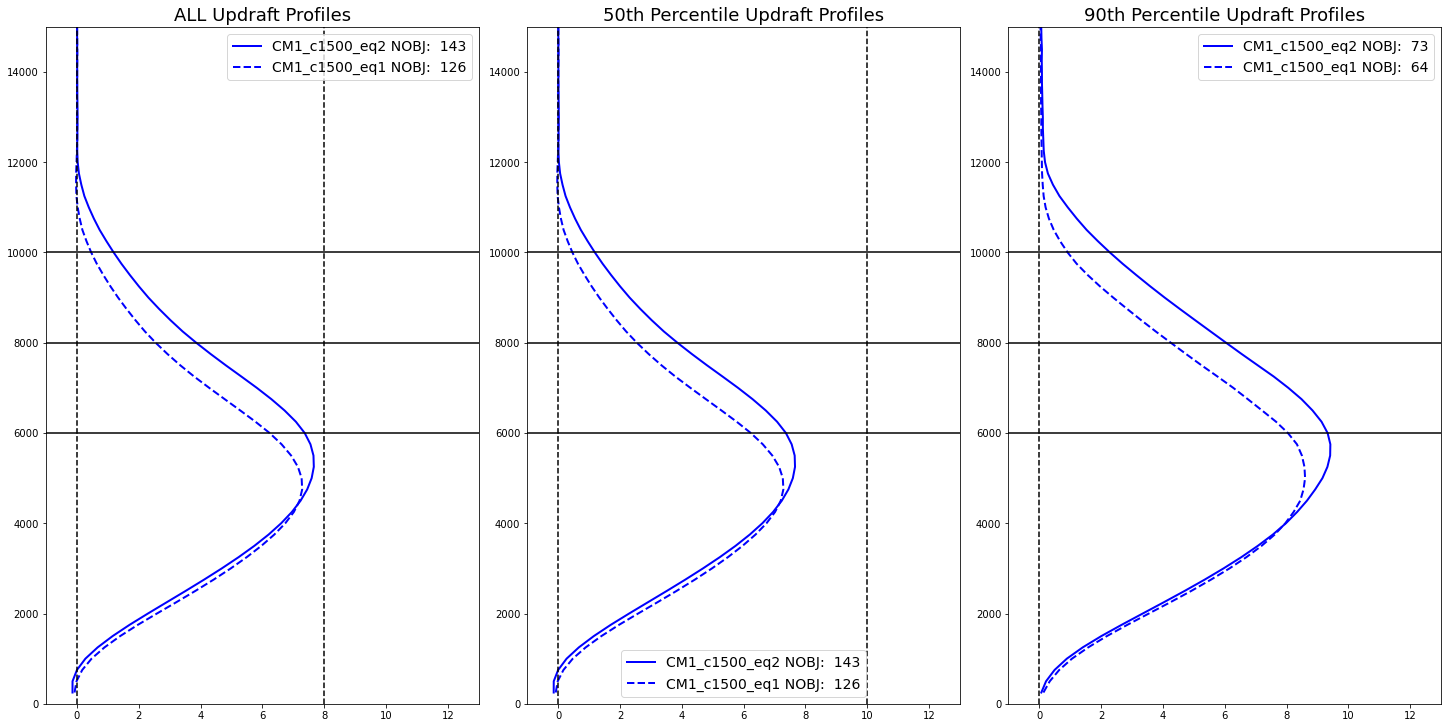

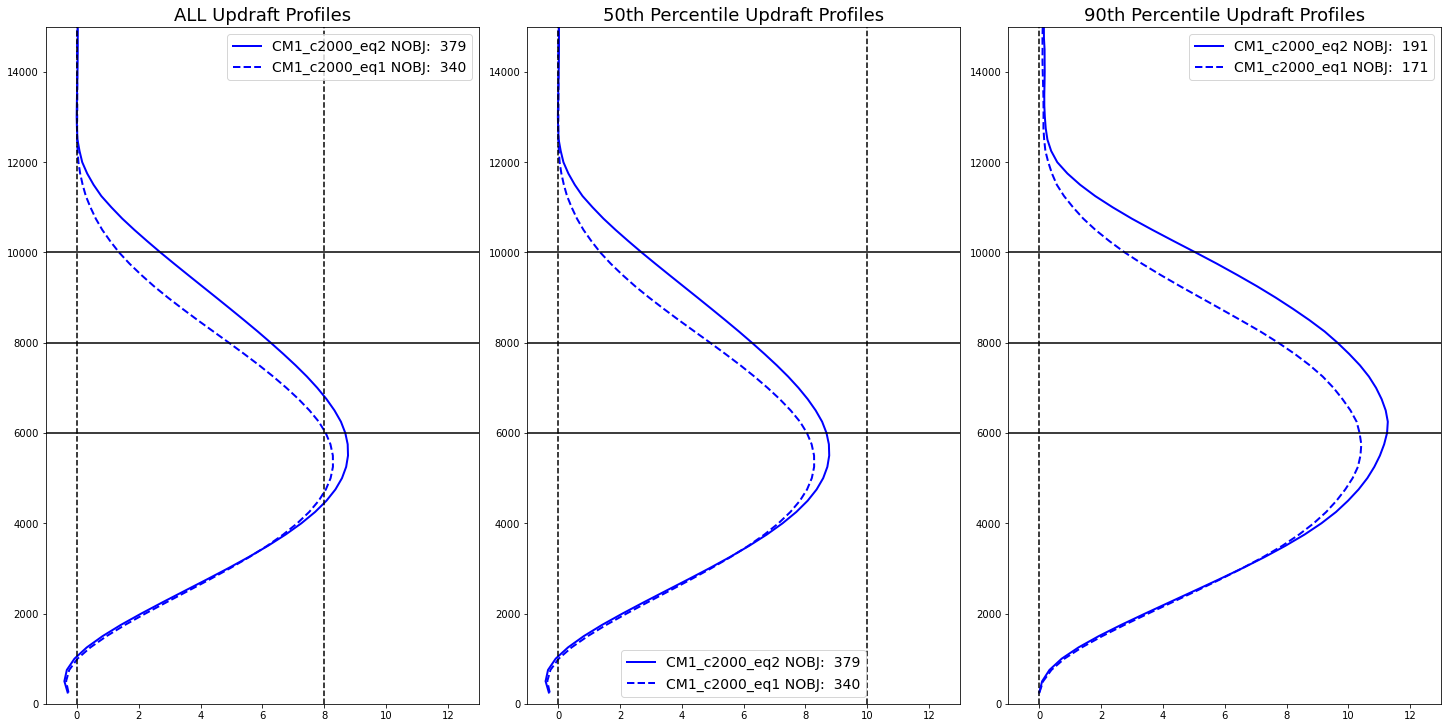

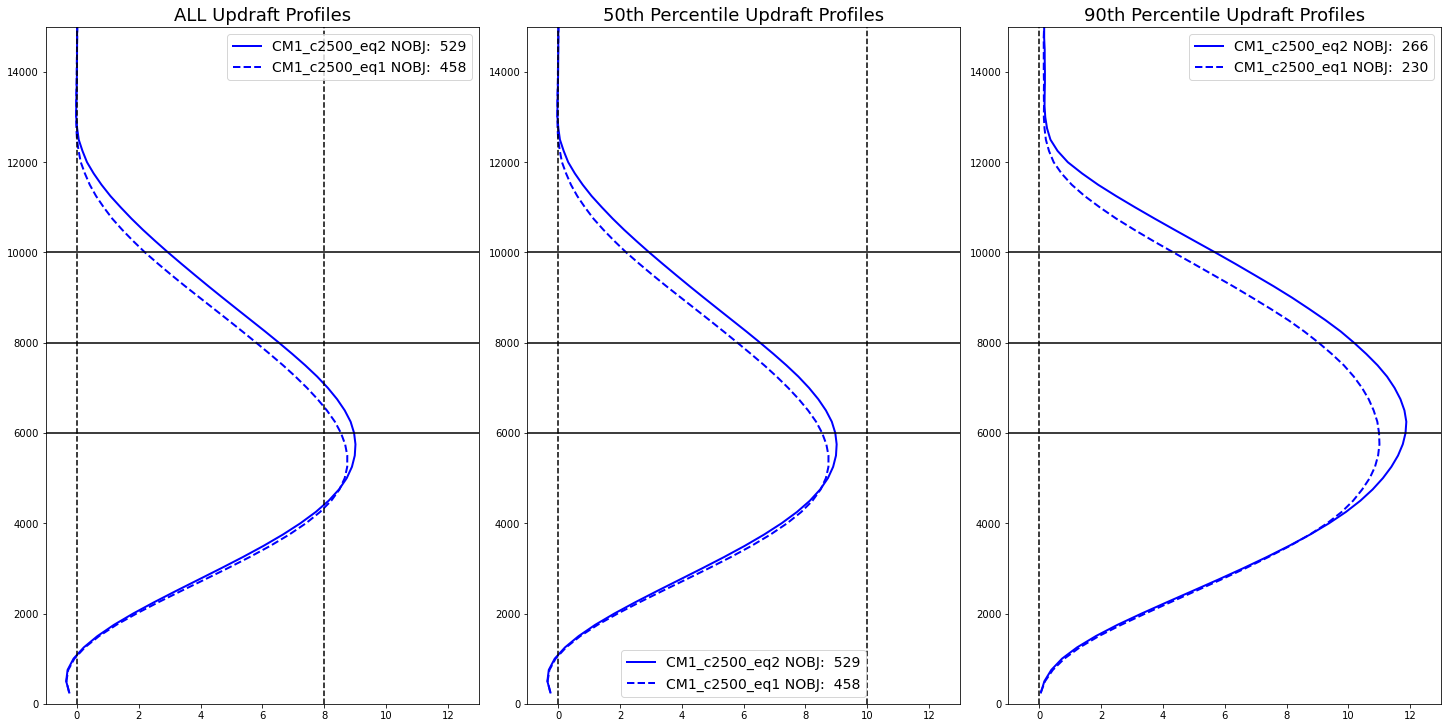

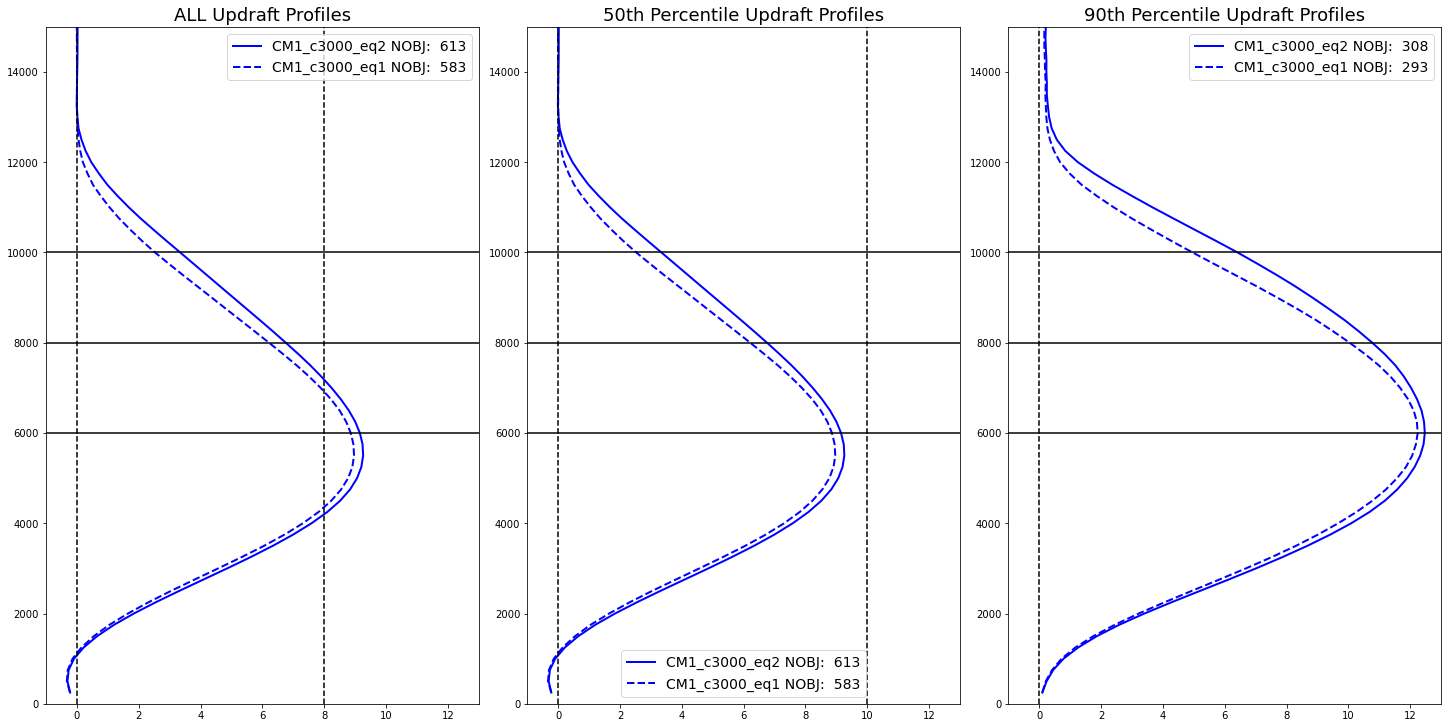

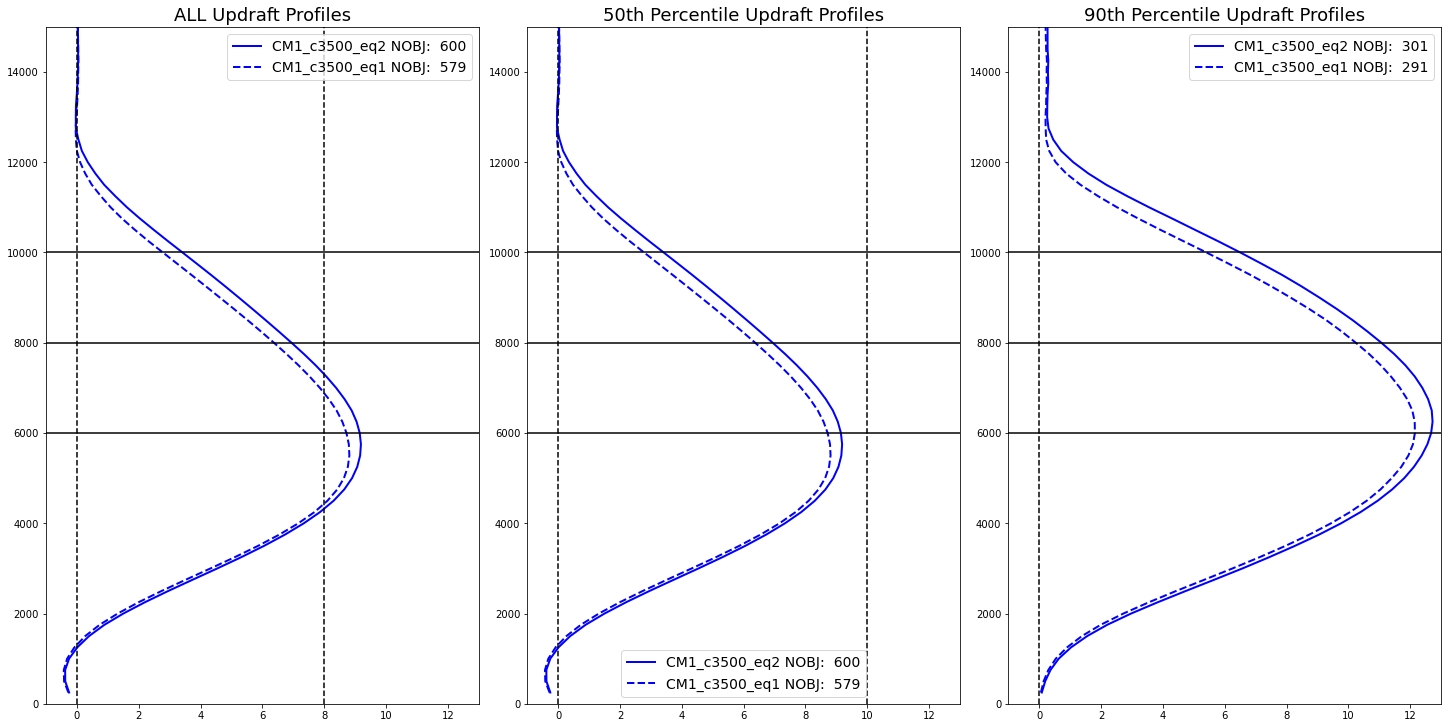

In [21]:
#--------------------------------------------------------------------------------------------
def plot_wprofile(profile, zhgts, percentile, ax, color, mlabel, linewidth=2.0, linestyle='solid'):

    label = "%s NOBJ:  %d" % (mlabel, profile[percentile].shape[1])
    
    ax.plot(profile[percentile].mean(axis=1), zhgts, color=color, linewidth=linewidth, label=label, linestyle=linestyle)
#--------------------------------------------------------------------------------------------
# main

titles = ["ALL Updraft Profiles", "50th Percentile Updraft Profiles", "90th Percentile Updraft Profiles", "95th Percentile Updraft Profiles"]

xvert  = [8.0, 10.0, 15.0, 17.5]
xlim   = [12.5, 15.0, 20.0, 20.0]
xlim   = [13.0, 13.0, 13.0, 13.0]

zhgts = 250. + 250.*np.arange(60)

fig, ax = plt.subplots(1,3, constrained_layout=True,figsize=(20,10))

for n in np.arange(3):
                   
    plot_wprofile(cm1_c1500_thom,     zhgts, n, ax[n], 'b', 'CM1_c1500_eq2')              
    plot_wprofile(cm1_c1500_thom_eq1, zhgts, n, ax[n], 'b', 'CM1_c1500_eq1', linestyle='dashed')
    
    ax[n].set_title("%s" % titles[n], fontsize=18)
    ax[n].axhline(y=6000., color='k', linestyle='-')
    ax[n].axhline(y=8000., color='k', linestyle='-')
    ax[n].axhline(y=10000., color='k', linestyle='-')
    ax[n].axvline(x=0.0, color='k', linestyle='--')
    ax[n].axvline(x=xvert[n], color='k', linestyle='--')

    ax[n].set_ylim(0.0,15000.)
    ax[n].set_xlim(-1.0,xlim[n])
    ax[n].legend(fontsize=14)

fig, ax = plt.subplots(1,3, constrained_layout=True,figsize=(20,10))

for n in np.arange(3):
                   
    plot_wprofile(cm1_c2000_thom,     zhgts, n, ax[n], 'b', 'CM1_c2000_eq2')              
    plot_wprofile(cm1_c2000_thom_eq1, zhgts, n, ax[n], 'b', 'CM1_c2000_eq1', linestyle='dashed')
    
    ax[n].set_title("%s" % titles[n], fontsize=18)
    ax[n].axhline(y=6000., color='k', linestyle='-')
    ax[n].axhline(y=8000., color='k', linestyle='-')
    ax[n].axhline(y=10000., color='k', linestyle='-')
    ax[n].axvline(x=0.0, color='k', linestyle='--')
    ax[n].axvline(x=xvert[n], color='k', linestyle='--')

    ax[n].set_ylim(0.0,15000.)
    ax[n].set_xlim(-1.0,xlim[n])
    ax[n].legend(fontsize=14)
   

#--------------

fig, ax = plt.subplots(1,3, constrained_layout=True,figsize=(20,10))

for n in np.arange(3):
                   
    plot_wprofile(cm1_c2500_thom,     zhgts, n, ax[n], 'b', 'CM1_c2500_eq2')              
    plot_wprofile(cm1_c2500_thom_eq1, zhgts, n, ax[n], 'b', 'CM1_c2500_eq1', linestyle='dashed')
    
    ax[n].set_title("%s" % titles[n], fontsize=18)
    ax[n].axhline(y=6000., color='k', linestyle='-')
    ax[n].axhline(y=8000., color='k', linestyle='-')
    ax[n].axhline(y=10000., color='k', linestyle='-')
    ax[n].axvline(x=0.0, color='k', linestyle='--')
    ax[n].axvline(x=xvert[n], color='k', linestyle='--')

    ax[n].set_ylim(0.0,15000.)
    ax[n].set_xlim(-1.0,xlim[n])
    ax[n].legend(fontsize=14)
    
#--------------

fig, ax = plt.subplots(1,3, constrained_layout=True,figsize=(20,10))

for n in np.arange(3):
                   
    plot_wprofile(cm1_c3000_thom,     zhgts, n, ax[n], 'b', 'CM1_c3000_eq2')              
    plot_wprofile(cm1_c3000_thom_eq1, zhgts, n, ax[n], 'b', 'CM1_c3000_eq1', linestyle='dashed')
    
    ax[n].set_title("%s" % titles[n], fontsize=18)
    ax[n].axhline(y=6000., color='k', linestyle='-')
    ax[n].axhline(y=8000., color='k', linestyle='-')
    ax[n].axhline(y=10000., color='k', linestyle='-')
    ax[n].axvline(x=0.0, color='k', linestyle='--')
    ax[n].axvline(x=xvert[n], color='k', linestyle='--')

    ax[n].set_ylim(0.0,15000.)
    ax[n].set_xlim(-1.0,xlim[n])
    ax[n].legend(fontsize=14)
    
#--------------

fig, ax = plt.subplots(1,3, constrained_layout=True,figsize=(20,10))

for n in np.arange(3):
                   
    plot_wprofile(cm1_c3500_thom,     zhgts, n, ax[n], 'b', 'CM1_c3500_eq2')              
    plot_wprofile(cm1_c3500_thom_eq1, zhgts, n, ax[n], 'b', 'CM1_c3500_eq1', linestyle='dashed')
    
    ax[n].set_title("%s" % titles[n], fontsize=18)
    ax[n].axhline(y=6000., color='k', linestyle='-')
    ax[n].axhline(y=8000., color='k', linestyle='-')
    ax[n].axhline(y=10000., color='k', linestyle='-')
    ax[n].axvline(x=0.0, color='k', linestyle='--')
    ax[n].axvline(x=xvert[n], color='k', linestyle='--')

    ax[n].set_ylim(0.0,15000.)
    ax[n].set_xlim(-1.0,xlim[n])
    ax[n].legend(fontsize=14)

In [15]:
with open(os.path.join('/work/wicker/WRF/WRF/test/em_quarter_ss/squall_3km_C2000_12', 'wrf_dbz.npy'), 'rb') as f:
    dbz = np.load(f)


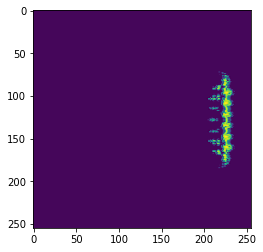

In [18]:
plt.imshow(dbz[10,10])